<a href="https://colab.research.google.com/github/K0k0drill0/machine_learning_6sem/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
ls

ex.csv	res.csv  sample_data  test.csv	train.csv


In [2]:
from typing import Literal
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

!gdown "1ZNw8d9M-xfzD1w5j1uVzCU_mrPeKJZAd" # download data to google colab environment
!gdown "1qSPKhv6Y4zBLHeAMfbQEAKHfrtW-z-G_"
!gdown "12J-8Wqpxyj9tUcQjdY0OcOqiddccE6FQ"


train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
ex_df = pd.read_csv('ex.csv')


Downloading...
From: https://drive.google.com/uc?id=1ZNw8d9M-xfzD1w5j1uVzCU_mrPeKJZAd
To: /content/train.csv
100% 3.41M/3.41M [00:00<00:00, 26.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qSPKhv6Y4zBLHeAMfbQEAKHfrtW-z-G_
To: /content/test.csv
100% 1.35M/1.35M [00:00<00:00, 12.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=12J-8Wqpxyj9tUcQjdY0OcOqiddccE6FQ
To: /content/ex.csv
100% 120k/120k [00:00<00:00, 4.00MB/s]


In [3]:
print(train_df.info())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

## Вспомогательные функции

In [4]:
sns.set(style="whitegrid")

def show_dependency(df, xcol, ycol):
    plt.figure(figsize=(10, 6))
    sns.regplot(x=xcol, y=ycol, data=df, scatter=True, line_kws={"color": "red"})
    plt.title(f'Зависимость между {xcol} и {ycol}')
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()


def plot_distributions(df, cols=None, kind='hist'):
    if cols is None:
        cols = df.select_dtypes(include=['number']).columns

    num_plots = len(cols)
    plt.figure(figsize=(12, num_plots * 4))

    for i, col in enumerate(cols, 1):
        plt.subplot(num_plots, 1, i)
        if kind == 'hist':
            sns.histplot(df[col], kde=True, bins=30, color='skyblue')
            plt.title(f'Гистограмма распределения {col}')
        elif kind == 'kde':
            sns.kdeplot(df[col], shade=True, color='purple')
            plt.title(f'KDE распределение {col}')
        elif kind == 'box':
            sns.boxplot(x=df[col], color='orange')
            plt.title(f'Box Plot распределения {col}')
        else:
            raise ValueError(f"Неизвестный тип графика: {kind}")

        plt.xlabel(col)
        plt.ylabel('Частота')

    plt.tight_layout()
    plt.show()

def show_real_and_predicted(y_test, y_pred):
    plt.figure(figsize=(10, 7))
    plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Предсказания')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Идеал')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Сравнение реальных и предсказанных значений RiskScore')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# ПОДГОТОВКА ДАННЫХ


Выделение числовых и категориальных признаков

In [5]:
print(train_df.isnull().sum())
only_riskscore_nans = train_df[
    train_df['RiskScore'].isnull() &
    train_df.drop(columns='RiskScore').notnull().all(axis=1)
]

print(f"Строк, где NaN только в RiskScore: {len(only_riskscore_nans)}")

nulldrop = train_df
nulldrop = train_df.drop(columns='RiskScore')
nulldrop = nulldrop.dropna()

total_rows = len(train_df)
remaining_rows = len(nulldrop)
deleted_rows = total_rows - remaining_rows
print(f"Удалено строк: {deleted_rows}")
print(f"Процент удалённых строк: {deleted_rows / total_rows * 100:.2f}%")

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

Строки, в которых содержится хотя бы 1

In [6]:
numeric_features = train_df.drop(columns='RiskScore').select_dtypes(np.number).columns
numeric_features

Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate',
       'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio',
       'LoanApproved'],
      dtype='object')

In [7]:
categorial_features = train_df.drop(columns='RiskScore').select_dtypes(object).columns
categorial_features

Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')

## Заполнение NaN

Так как null в RiskScore встречается редко (к тому же каждый такой случай имеет null еще и в других столбцах, то можно его удалить)

In [8]:
print(len(train_df))
train_df = train_df.dropna(subset=['RiskScore'])
print(len(train_df))
print(train_df.isnull().sum())

11017
10487
ApplicationDate                 0
Age                             0
AnnualIncome                    0
CreditScore                   501
LoanAmount                    501
LoanDuration                    0
MaritalStatus                   0
NumberOfDependents              0
HomeOwnershipStatus             0
MonthlyDebtPayments           501
CreditCardUtilizationRate       0
NumberOfOpenCreditLines         0
NumberOfCreditInquiries         0
DebtToIncomeRatio               0
BankruptcyHistory             501
LoanPurpose                   501
PreviousLoanDefaults            0
PaymentHistory                  0
LengthOfCreditHistory           0
SavingsAccountBalance           0
CheckingAccountBalance        501
TotalAssets                   501
TotalLiabilities                0
MonthlyIncome                   0
UtilityBillsPaymentHistory      0
JobTenure                       0
EmploymentStatus                0
EducationLevel                  0
Experience                      0
Ne

Для оставшихся столбцов числовые данные будем заполнять средним, а категориальные - медианным

In [9]:
for col in train_df.select_dtypes(include=np.number):
    train_df[col] = train_df[col].fillna(train_df[col].mean())

for col in train_df.select_dtypes(include=object):
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

print(train_df.isnull().sum())

ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
Interest

<ipython-input-9-991b3435e37d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].fillna(train_df[col].mean())
<ipython-input-9-991b3435e37d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].fillna(train_df[col].mode()[0])


## Удаление дубликатов


In [10]:
print(len(train_df))
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
print(len(train_df))

10487
10000


## Обработка категориальных признаков

Сначала преобразуем ApplicationDate. Разобьем его на year, month и day

In [11]:
print(pd.to_datetime(train_df['ApplicationDate'][0]))

2010-06-26 00:00:00


In [12]:
def transform_application_date(df):
    tmp = df.copy()
    tmp['ApplicationDate'] = pd.to_datetime(tmp['ApplicationDate'])
    tmp['ApplicationYear'] = tmp['ApplicationDate'].dt.year
    tmp['ApplicationMonth'] = tmp['ApplicationDate'].dt.month
    tmp['ApplicationDay'] = tmp['ApplicationDate'].dt.day

    tmp = tmp.drop(columns=['ApplicationDate'])
    return tmp

train_df = transform_application_date(train_df)
test_df = transform_application_date(test_df)

print(train_df['ApplicationYear'][0])
print(train_df['ApplicationMonth'][0])
print(train_df['ApplicationDay'][0])

print(train_df.info())

2010
6
26
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         10000 non-null  float64
 1   AnnualIncome                10000 non-null  float64
 2   CreditScore                 10000 non-null  float64
 3   LoanAmount                  10000 non-null  float64
 4   LoanDuration                10000 non-null  float64
 5   MaritalStatus               10000 non-null  object 
 6   NumberOfDependents          10000 non-null  float64
 7   HomeOwnershipStatus         10000 non-null  object 
 8   MonthlyDebtPayments         10000 non-null  float64
 9   CreditCardUtilizationRate   10000 non-null  float64
 10  NumberOfOpenCreditLines     10000 non-null  float64
 11  NumberOfCreditInquiries     10000 non-null  float64
 12  DebtToIncomeRatio           10000 non-null  float64
 13  BankruptcyHistory          

In [13]:
print(categorial_features)
for i in range(len(categorial_features)):
    if (categorial_features[i] == 'ApplicationDate'):
        categorial_features = categorial_features.delete(i)
        break

train_df = pd.get_dummies(train_df, columns=categorial_features, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorial_features, drop_first=True)


Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')


Теперь обработаем выбросы

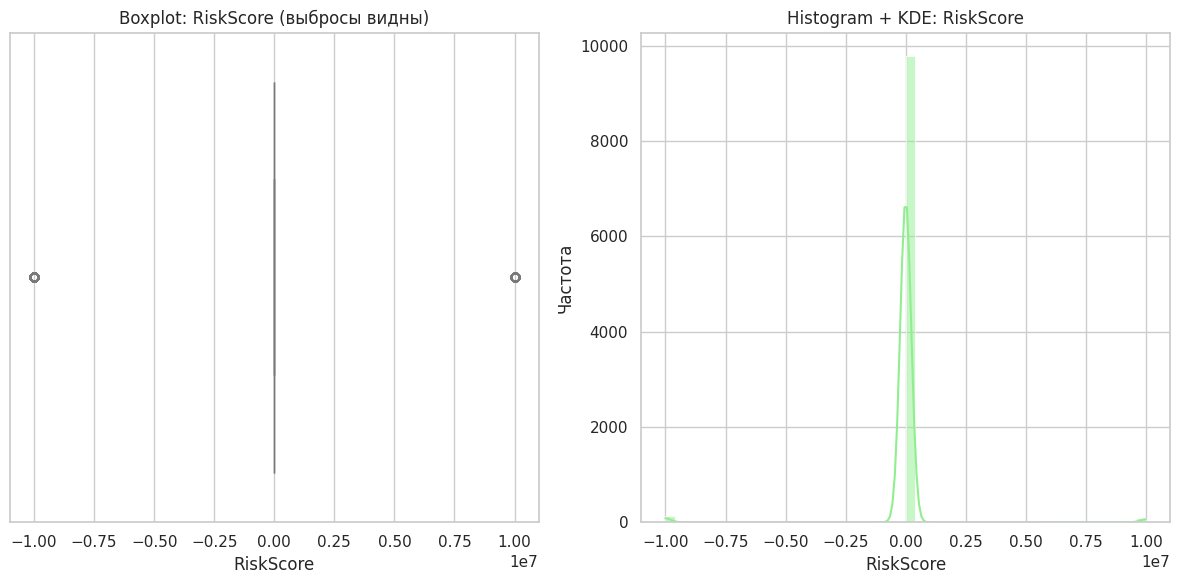

In [14]:
plt.figure(figsize=(12, 6))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=train_df['RiskScore'], color='lightblue')
plt.title('Boxplot: RiskScore (выбросы видны)')

# гистограмма + KDE
plt.subplot(1, 2, 2)
sns.histplot(train_df['RiskScore'], bins=50, kde=True, color='lightgreen')
plt.title('Histogram + KDE: RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По графикам видно, что есть выбросы, сильно отличающиеся от большей части значений

In [15]:
print(np.sort(train_df['RiskScore'].unique()))

[-9.99999900e+06  1.48414173e+01  1.78355914e+01 ...  9.61725405e+01
  9.75972494e+01  1.00000000e+07]


Судя по всему, все данные находятся в диапазоне от 0 до 100, а остальные числа скорее всего были заглушками.

In [16]:
train_df = train_df[((train_df['RiskScore'] > 0) & (train_df['RiskScore'] < 100))]

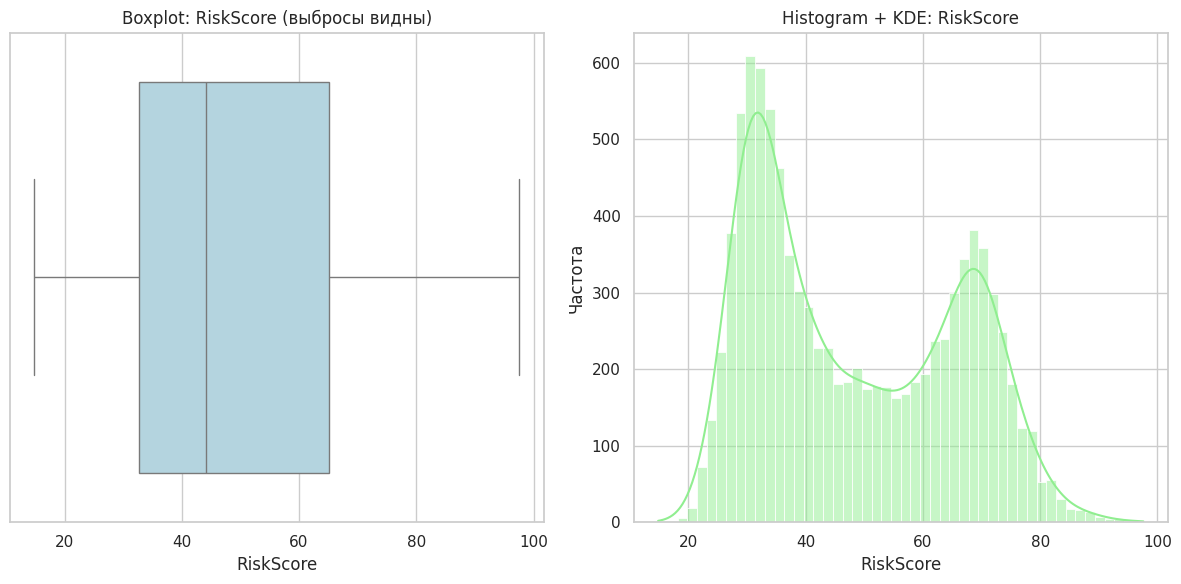

In [17]:
plt.figure(figsize=(12, 6))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=train_df['RiskScore'], color='lightblue')
plt.title('Boxplot: RiskScore (выбросы видны)')

# гистограмма + KDE
plt.subplot(1, 2, 2)
sns.histplot(train_df['RiskScore'], bins=50, kde=True, color='lightgreen')
plt.title('Histogram + KDE: RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

## Разведочный анализ данных

# Исследование мультиколлинеарности

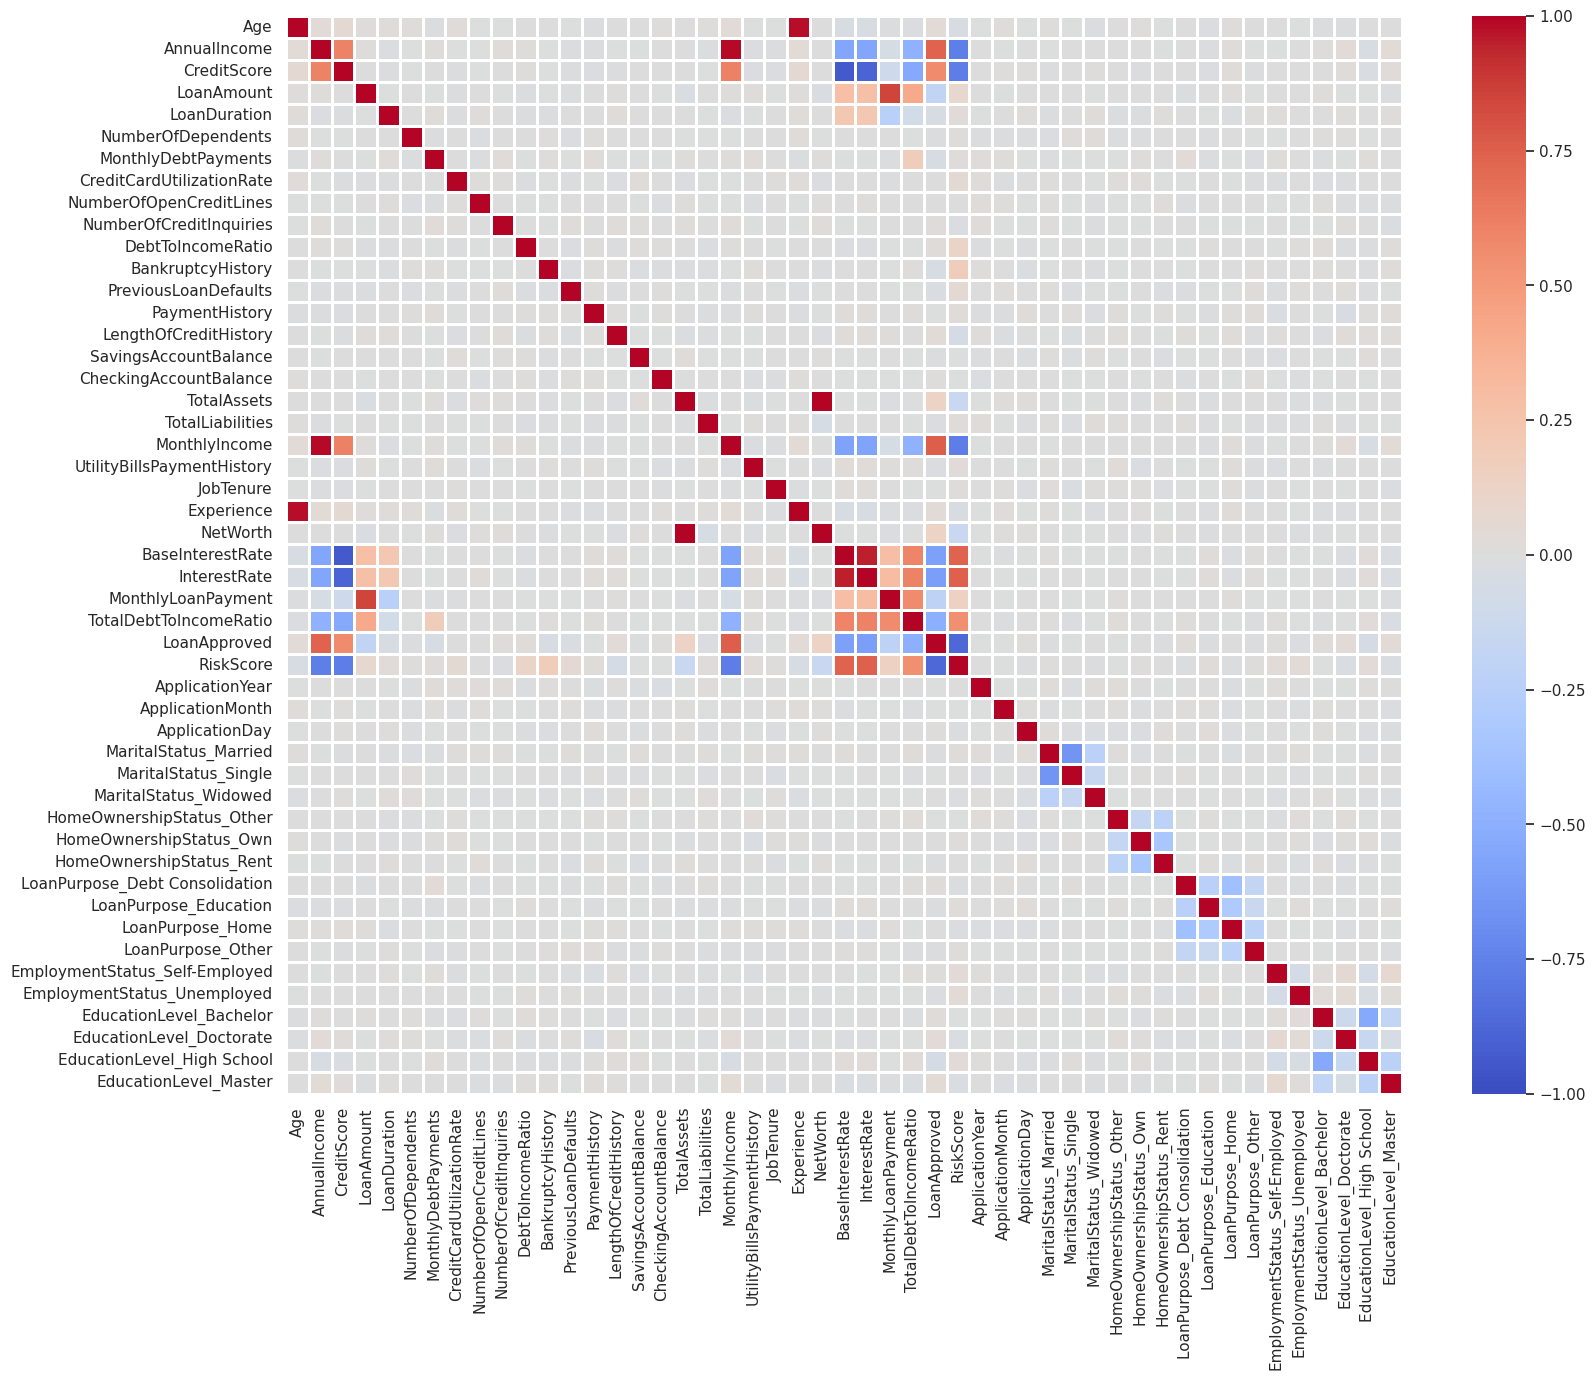

In [18]:
corr_matrix = train_df.corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix,
            # annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=1)
plt.show()

In [19]:
high_corr = corr_matrix[(abs(corr_matrix) >= 0.7) & (corr_matrix != 1.0)].stack()

low_corr = corr_matrix[(abs(corr_matrix) <= 0.1)].stack()
print(high_corr)
print(low_corr[::100])

Age                 Experience            0.982817
AnnualIncome        MonthlyIncome         0.984905
                    LoanApproved          0.741913
                    RiskScore            -0.757883
CreditScore         BaseInterestRate     -0.932614
                    InterestRate         -0.886979
                    RiskScore            -0.767332
LoanAmount          MonthlyLoanPayment    0.848188
TotalAssets         NetWorth              0.993819
MonthlyIncome       AnnualIncome          0.984905
                    LoanApproved          0.754304
                    RiskScore            -0.769977
Experience          Age                   0.982817
NetWorth            TotalAssets           0.993819
BaseInterestRate    CreditScore          -0.932614
                    InterestRate          0.952025
                    RiskScore             0.742047
InterestRate        CreditScore          -0.886979
                    BaseInterestRate      0.952025
                    RiskScore  

Некоторые графики сильной корреляции

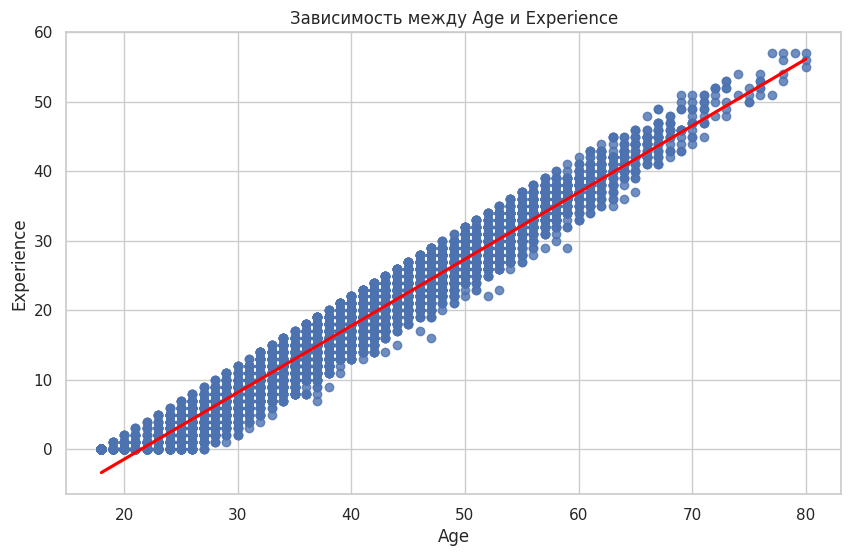

In [20]:
show_dependency(train_df, 'Age', 'Experience')

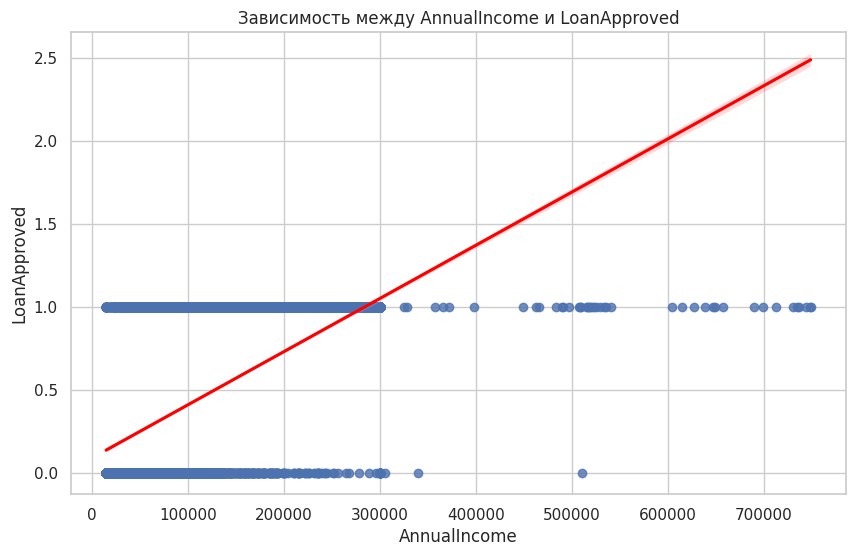

In [21]:
show_dependency(train_df, 'AnnualIncome', 'LoanApproved')

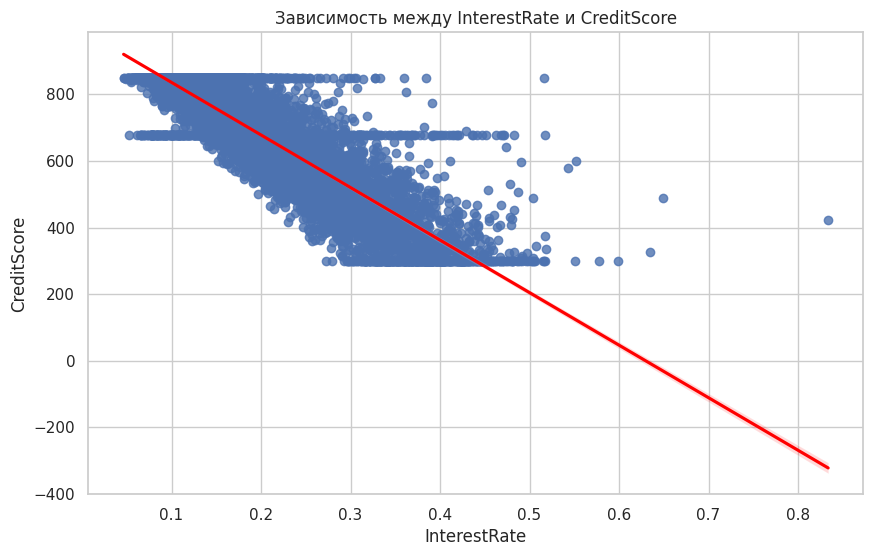

In [22]:
show_dependency(train_df, 'InterestRate', 'CreditScore')

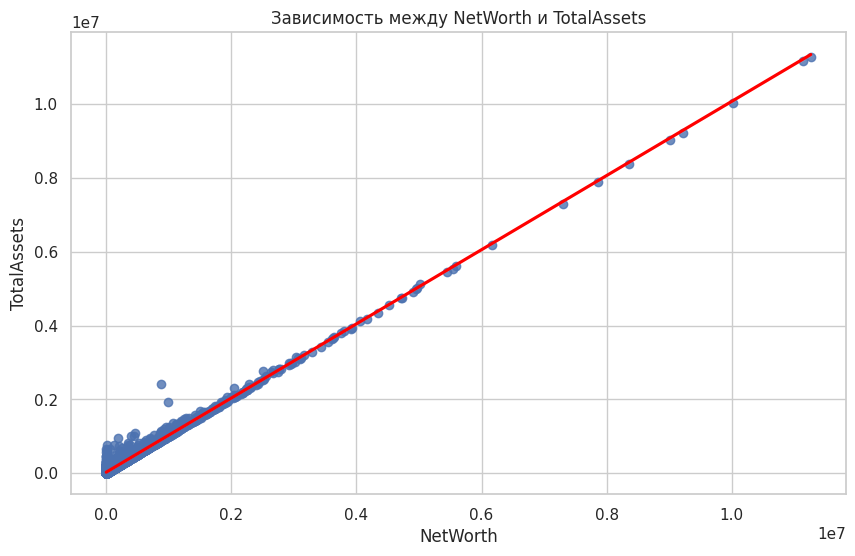

In [23]:
show_dependency(train_df, 'NetWorth', 'TotalAssets')

Некоторые графики слабой корреляции

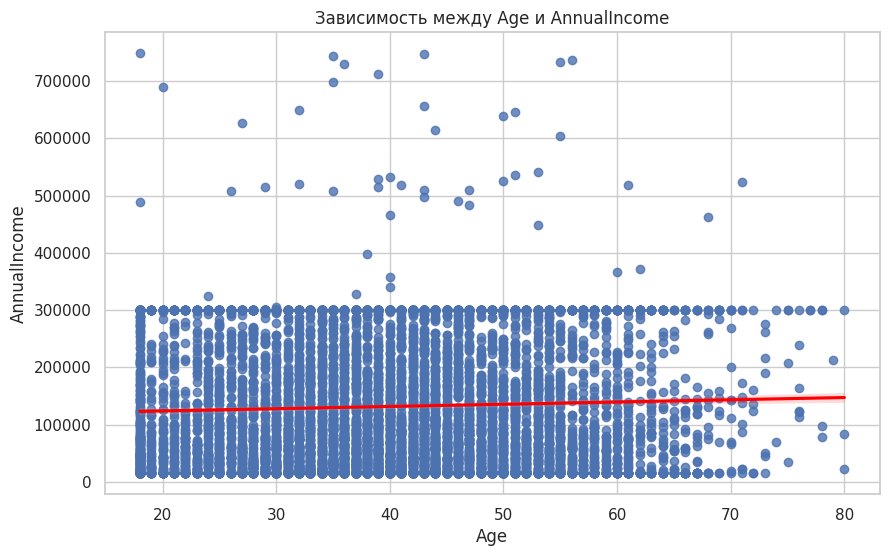

In [24]:
show_dependency(train_df, 'Age', 'AnnualIncome')

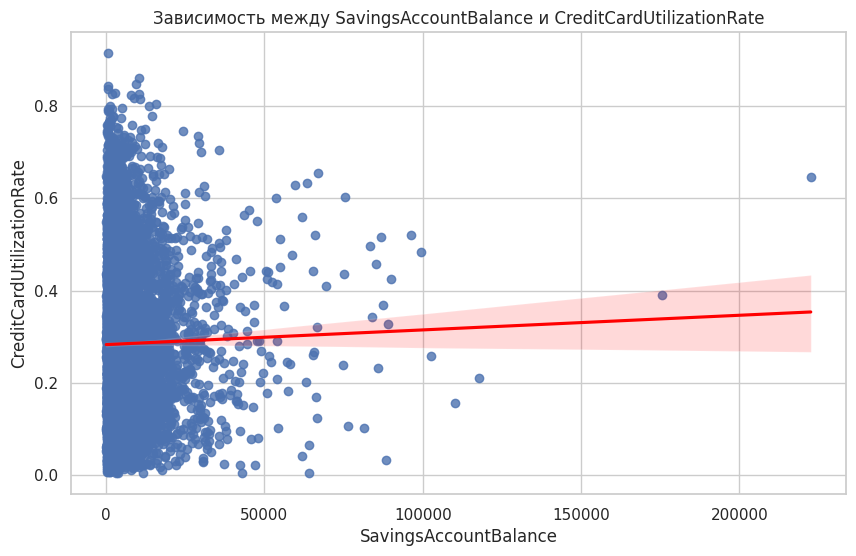

In [25]:
show_dependency(train_df, 'SavingsAccountBalance', 'CreditCardUtilizationRate')

# Разрешение мультиколлинеарности признаков

In [26]:
print(high_corr)

Age                 Experience            0.982817
AnnualIncome        MonthlyIncome         0.984905
                    LoanApproved          0.741913
                    RiskScore            -0.757883
CreditScore         BaseInterestRate     -0.932614
                    InterestRate         -0.886979
                    RiskScore            -0.767332
LoanAmount          MonthlyLoanPayment    0.848188
TotalAssets         NetWorth              0.993819
MonthlyIncome       AnnualIncome          0.984905
                    LoanApproved          0.754304
                    RiskScore            -0.769977
Experience          Age                   0.982817
NetWorth            TotalAssets           0.993819
BaseInterestRate    CreditScore          -0.932614
                    InterestRate          0.952025
                    RiskScore             0.742047
InterestRate        CreditScore          -0.886979
                    BaseInterestRate      0.952025
                    RiskScore  

Как видно, многие признаки очень сильно коррелируют друг с другом, поэтому можно воспользоваться одним из методов устранения мультиколлинеарности.

In [27]:
pr_train_df = train_df.copy()
pr_test_df = test_df.copy()

Воспользуемся Лассо-регрессией для решения проблемы мультиколлинеарности

In [28]:
X = train_df.drop(columns=['RiskScore'])
y = train_df['RiskScore']

# Разделим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

skmodel = Lasso(alpha=0.3)
skmodel.fit(X_train, y_train)
y_pred = skmodel.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Коэффициенты модели: {skmodel.coef_}")

coefs = skmodel.coef_
feature_names = X.columns
unimportant_features = feature_names[coefs == 0]
unimportant_features

# обучить с l2 регуляризацией
# полиномы с этими коэффициентами

MSE: 31.21620997159299
Коэффициенты модели: [ 3.00432619e-03 -1.23352735e-06 -3.92054754e-02 -9.11451625e-06
  1.31492151e-03  0.00000000e+00 -1.05499816e-04  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  4.73649722e-01  5.74672452e+00
  0.00000000e+00  1.76439357e-03 -9.60370060e-02 -9.28166803e-06
  1.12564341e-05 -6.04279278e-06  1.20485431e-06 -3.05163974e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.80443811e-06
  0.00000000e+00  0.00000000e+00  6.45340454e-06  3.34465856e-01
 -1.58756037e+01  3.35981880e-03 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+04, tolerance: 2.311e+02
  model = cd_fast.enet_coordinate_descent(


Index(['NumberOfDependents', 'CreditCardUtilizationRate',
       'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
       'PreviousLoanDefaults', 'UtilityBillsPaymentHistory', 'JobTenure',
       'Experience', 'BaseInterestRate', 'InterestRate', 'ApplicationMonth',
       'ApplicationDay', 'MaritalStatus_Married', 'MaritalStatus_Single',
       'MaritalStatus_Widowed', 'HomeOwnershipStatus_Other',
       'HomeOwnershipStatus_Own', 'HomeOwnershipStatus_Rent',
       'LoanPurpose_Debt Consolidation', 'LoanPurpose_Education',
       'LoanPurpose_Home', 'LoanPurpose_Other',
       'EmploymentStatus_Self-Employed', 'EmploymentStatus_Unemployed',
       'EducationLevel_Bachelor', 'EducationLevel_Doctorate',
       'EducationLevel_High School', 'EducationLevel_Master'],
      dtype='object')

Теперь нужно оставить только те столбцы, которые мы получили с помощью Лассо регрессии

In [29]:
pr_train_df = pr_train_df.drop(columns=unimportant_features)

pr_test_df = pr_test_df.drop(columns=unimportant_features)

In [30]:
pr_train_df.info()
pr_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9788 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     9788 non-null   float64
 1   AnnualIncome            9788 non-null   float64
 2   CreditScore             9788 non-null   float64
 3   LoanAmount              9788 non-null   float64
 4   LoanDuration            9788 non-null   float64
 5   MonthlyDebtPayments     9788 non-null   float64
 6   DebtToIncomeRatio       9788 non-null   float64
 7   BankruptcyHistory       9788 non-null   float64
 8   PaymentHistory          9788 non-null   float64
 9   LengthOfCreditHistory   9788 non-null   float64
 10  SavingsAccountBalance   9788 non-null   float64
 11  CheckingAccountBalance  9788 non-null   float64
 12  TotalAssets             9788 non-null   float64
 13  TotalLiabilities        9788 non-null   float64
 14  MonthlyIncome           9788 non-null   float

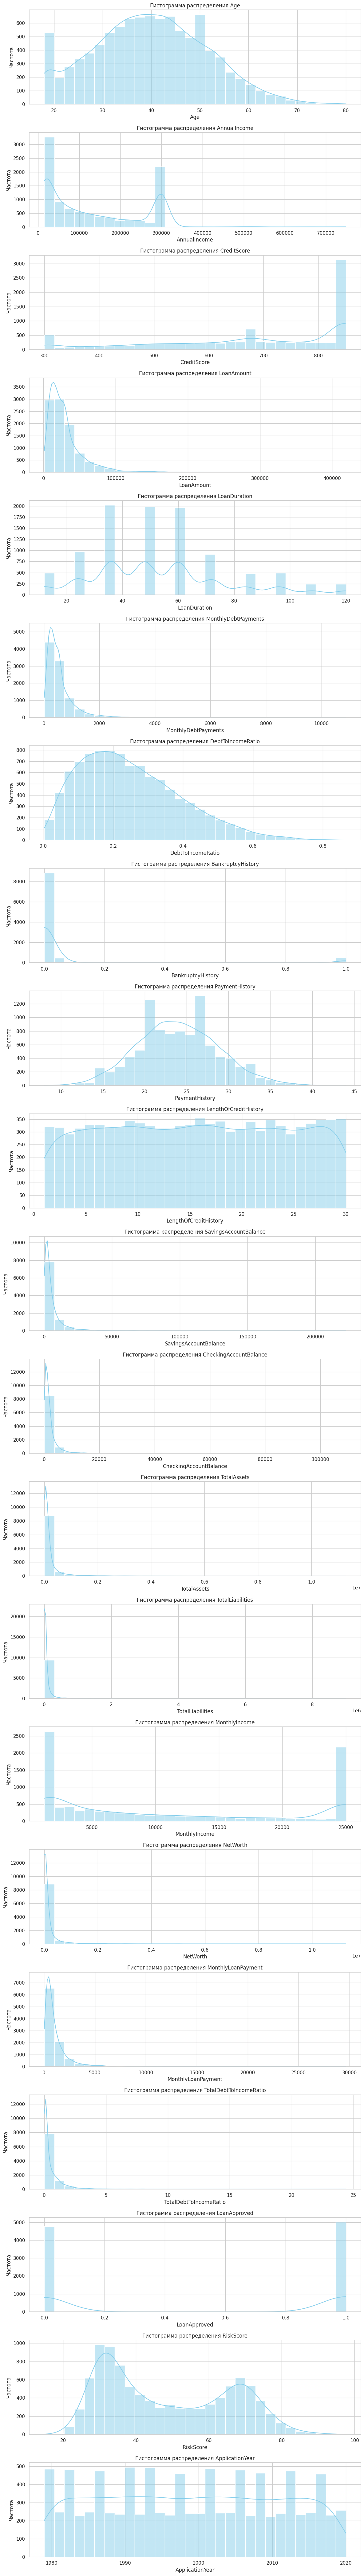

In [31]:
pr_train_df.columns

plot_distributions(pr_train_df, pr_train_df.columns)

## Нормализация данных

In [32]:
features_to_log = ['LoanAmount', 'MonthlyDebtPayments', 'DebtToIncomeRatio',
                   'TotalAssets','TotalLiabilities', 'MonthlyLoanPayment',
                   'TotalDebtToIncomeRatio']

for feature in features_to_log:
    pr_train_df[feature] = np.log(pr_train_df[feature].replace(0, 1e-9))
    pr_test_df[feature] = np.log(pr_test_df[feature].replace(0, 1e-9))


In [33]:
scaler = StandardScaler()

features_to_normalize = ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MonthlyDebtPayments',
                         'DebtToIncomeRatio', 'PaymentHistory',
                         'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome',
                         'NetWorth', 'MonthlyLoanPayment',
                         'TotalDebtToIncomeRatio', 'ApplicationYear']

for feature in features_to_normalize:
    pr_train_df[[feature]] = scaler.fit_transform(pr_train_df[[feature]])
    pr_test_df[[feature]] = scaler.fit_transform(pr_test_df[[feature]])


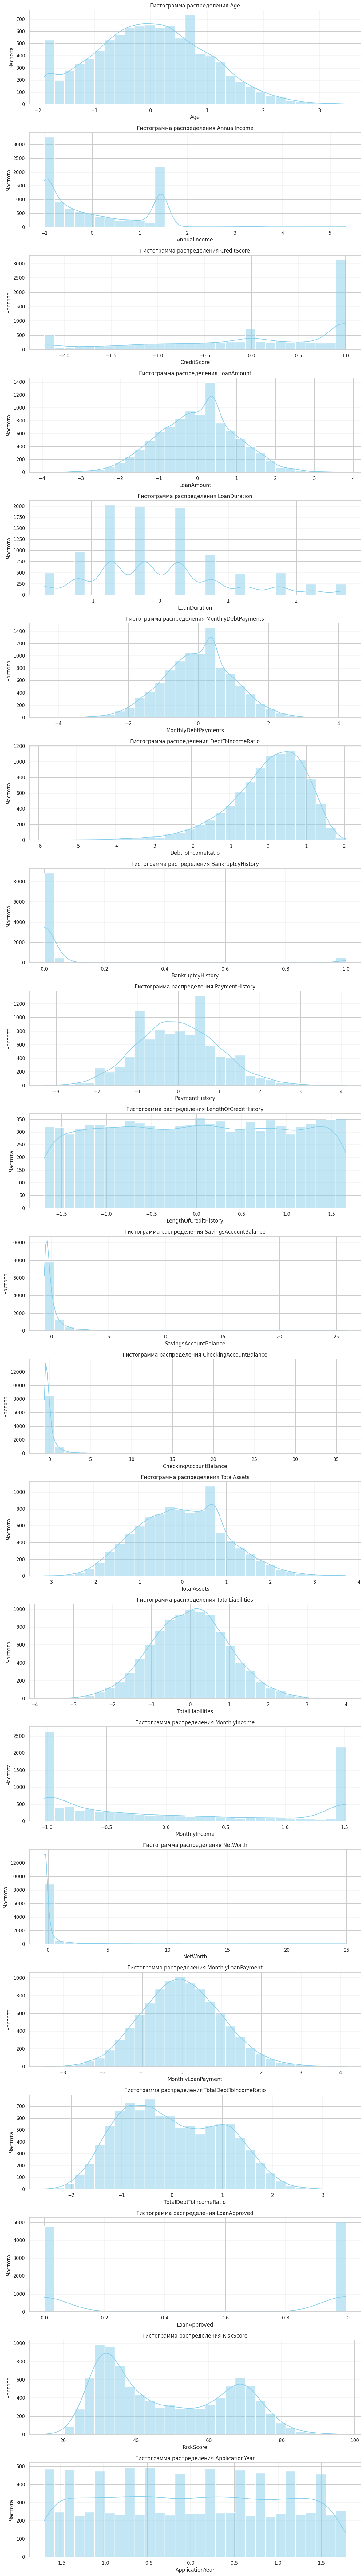

In [34]:
plot_distributions(pr_train_df)

# Алгоритмы

In [35]:
import numpy as np
import time
from typing import Literal

class LinearRegression:
    class Metrics:
        @staticmethod
        def mse(X, y, w, b):
            return np.mean((X.dot(w) + b - y) ** 2)

        @staticmethod
        def mse(X, y, w, b):
            return np.mean((X.dot(w) + b - y) ** 2)

        @staticmethod
        def mae(X, y, w, b):
            return np.mean(np.abs(X.dot(w) + b - y))

        @staticmethod
        def r2_score(X, y, w, b):
            return 1 - np.sum((X.dot(w) + b - y) ** 2) / np.sum((np.mean(y) - y) ** 2)

        @staticmethod
        def mape(X, y, w, b):
            return np.mean(np.abs(X.dot(w) + b - y) / np.abs(y))


    class Analytical:
        def __init__(self, reg=None, alpha=0.01):
            self.reg = reg
            self.alpha = alpha
            self.weights = None
            self.bias = 0.0

        def fit(self, X, y):
            X = np.insert(X, 0, 1, axis=1)
            X_T_X = X.T @ X
            if self.reg == "l2":
                X_T_X += self.alpha * np.eye(X_T_X.shape[0])
            inverse = np.linalg.pinv(X_T_X)
            w = inverse @ X.T @ y
            self.bias = w[0]
            self.weights = w[1:]

        def predict(self, X):
            return X @ self.weights + self.bias

    class GradientDescent:
        def __init__(self, loss="mse", reg=None, reg_coef=0.01, learning_rate=0.01, n_iter=1000, p=1.5):
            self.loss = loss
            self.reg = reg
            self.reg_coef = reg_coef
            self.learning_rate = learning_rate
            self.n_iter = n_iter
            self.p = p
            self.weights = None
            self.bias = 0.0

        def _regularize(self, dw):
            if self.reg == 'l1':
                return dw + self.reg_coef * np.sign(self.weights)
            elif self.reg == 'l2':
                return dw + self.reg_coef * self.weights
            elif self.reg == 'lp':
                return dw + self.reg_coef * np.power(np.abs(self.weights), self.p - 1) * np.sign(self.weights)
            elif self.reg == 'l1+l2':
                return dw + self.reg_coef * (np.sign(self.weights) + self.weights)
            return dw

        def fit(self, X, y):
            n_samples, n_features = X.shape
            self.weights = np.zeros(n_features)

            for _ in range(self.n_iter):
                y_pred = np.dot(X, self.weights) + self.bias
                error = y_pred - y

                # Градиенты
                dw = (1 / n_samples) * np.dot(X.T, error)
                db = (1 / n_samples) * np.sum(error)

                # Регуляризация
                dw = self._regularize(dw)

                # Обновление весов
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

        def predict(self, X):
            return np.dot(X, self.weights) + self.bias

    class StochasticGradientDescent:
        def __init__(self,
                    learn_coef=0.01,
                    learn_pow=0.25,
                    max_iter=1000,
                    reg: Literal['l1', 'l2', 'elasticnet', 'lp', None] = None,
                    reg_coef=0.0001,
                    net_l1_ratio=0.15,
                    p=2,
                    random_state=None):
            if not (0 <= net_l1_ratio <= 1):
                raise ValueError('net_l1_ratio must be in [0;1]')
            if p <= 0:
                raise ValueError('p must be a positive number')
            if random_state is None:
                random_state = round(time.time())

            self.learn_coef = learn_coef
            self.learn_pow = learn_pow
            self.max_iter = max_iter
            self.reg = reg
            self.reg_coef = reg_coef
            self.net_l1_ratio = net_l1_ratio
            self.p = p
            self.bias = 0
            self.weights = None
            self.rng = np.random.default_rng(seed=random_state)

        def _learning_rate(self, t):
            return self.learn_coef / (t + 1) ** self.learn_pow

        def _regularization_grad(self, weights):
            if self.reg is None:
                return np.zeros_like(weights)
            elif self.reg == 'l2':
                return self.reg_coef * weights
            elif self.reg == 'l1':
                return self.reg_coef * np.sign(weights)
            elif self.reg == 'elasticnet':
                l1 = self.net_l1_ratio * np.sign(weights)
                l2 = (1 - self.net_l1_ratio) * weights
                return self.reg_coef * (l1 + l2)
            elif self.reg == 'lp':
                norm_p = np.linalg.norm(weights, ord=self.p)
                if norm_p == 0:
                    return np.zeros_like(weights)
                grad = self.p * np.sign(weights) * np.abs(weights) ** (self.p - 1)
                return self.reg_coef * grad
            else:
                raise ValueError(f"Unsupported regularization: {self.regularization}")

        def fit(self, X, y):
            X = np.asarray(X)
            y = np.asarray(y)
            n_samples, n_features = X.shape
            self.weights = np.zeros(n_features)
            self.bias = 0

            for t in range(self.max_iter):
                i = self.rng.integers(0, n_samples)
                xi = X[i]
                yi = y[i]

                prediction = np.dot(xi, self.weights) + self.bias
                error = prediction - yi

                lr = self._learning_rate(t)
                grad_w = error * xi + self._regularization_grad(self.weights)
                grad_b = error

                self.weights -= lr * grad_w
                self.bias -= lr * grad_b

        def predict(self, X):
            X = np.asarray(X)
            return np.dot(X, self.weights) + self.bias

In [36]:
class Normalization:
    @staticmethod
    def ZScoreScaler(X):
        return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    @staticmethod
    def MinMaxScaler(X):
        return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [37]:
def manual_k_fold_cv(model_class, X, y, k=5, **model_kwargs):
    n = len(X)
    indices = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(indices)

    fold_sizes = np.full(k, n // k)
    fold_sizes[:n % k] += 1

    current = 0
    mse_list, mae_list, mape_list, r2_list = [], [], [], []

    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        current = stop

        model = model_class(**model_kwargs)
        model.fit(X[train_idx], y[train_idx])
        y_pred = X[test_idx] @ model.weights + model.bias
        y_true = y[test_idx]

        mse_list.append(mean_squared_error(y_true, y_pred))
        mae_list.append(mean_absolute_error(y_true, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_true, y_pred))
        r2_list.append(r2_score(y_true, y_pred))

    return {
        'mse': mse_list,
        'mae': mae_list,
        'mape': mape_list,
        'r2': r2_list
    }


def manual_leave_one_out_cv(model_class, X, y, **model_kwargs):
    n = len(X)
    mse_list, mae_list, mape_list = [], [], []

    for i in range(n):
        train_idx = np.delete(np.arange(n), i)
        test_idx = [i]

        model = model_class(**model_kwargs)
        model.fit(X[train_idx], y[train_idx])
        y_pred = X[i] @ model.weights + model.bias
        y_true = y[i]

        mse_list.append((y_true - y_pred) ** 2)
        mae_list.append(abs(y_true - y_pred))
        mape_list.append(abs((y_true - y_pred) / y_true) if y_true != 0 else 0)

    total_ss = np.sum((y - np.mean(y)) ** 2)
    residual_ss = np.sum(mse_list)
    r2 = 1 - residual_ss / total_ss

    return {
        'mse': mse_list,
        'mae': mae_list,
        'mape': mape_list,
        'r2': [r2]
    }


## Тестирование алгоритмов

In [38]:
def print_my_metrics(X_test, y_test, weights, bias):
    print(f'MSE: {LinearRegression.Metrics.mse(X_test, y_test, weights, bias)}')
    print(f'MAPE: {LinearRegression.Metrics.mape(X_test, y_test, weights, bias)}')
    print(f'MAE: {LinearRegression.Metrics.mae(X_test, y_test, weights, bias)}')
    print(f'r2_score: {LinearRegression.Metrics.r2_score(X_test, y_test, weights, bias)}')

def print_sklear_metrics(y_test, y_pred):
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'r2_score: {r2_score(y_test, y_pred)}')

In [39]:
X = pr_train_df.drop(columns=['RiskScore'])
y = pr_train_df['RiskScore']

Пришлось добавить полиномизацию, так как без неё MSE была очень большой

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_train_df = poly.fit_transform(X)

print(f"Количество признаков до полиномизации: {X.shape[1]}")
print(f"Количество признаков после полиномизации: {poly_train_df.shape[1]}")

Количество признаков до полиномизации: 20
Количество признаков после полиномизации: 230


MSE Линейной регрессии, вычисленной по формуле

In [41]:
X_train, X_test, y_train, y_test = train_test_split(poly_train_df, y, test_size=0.2, random_state=42)
model = LinearRegression.Analytical()

model.fit(X_train, y_train)
print_my_metrics(X_test, y_test, model.weights, model.bias)

MSE: 15.994405985251868
MAPE: 0.07182468821651809
MAE: 3.1022626259695256
r2_score: 0.9473928430738822


Теперь встроенная линейная регрессия:

In [42]:
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print_sklear_metrics(y_test, y_pred)

MSE: 15.99440598526958
MAPE: 0.07182468821656643
MAE: 3.1022626259710093
r2_score: 0.9473928430738239


Протестируем гардиентный спуск

In [51]:
import time

X_train, X_test, y_train, y_test = train_test_split(pr_train_df.drop(columns=['RiskScore']), y, test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

regs = ['l1', 'l2', 'elasticnet']

for reg in regs:
    print(f'My GradientDescent with {reg}')
    start = time.time()
    model = LinearRegression.GradientDescent(reg=reg)
    model.fit(X_train, y_train)
    duration = time.time() - start
    print(f"Время обучения: {duration:.4f} секунд")
    print_my_metrics(X_test, y_test, model.weights, model.bias)
    print("")

    print(f'My StochasticGradientDescent with {reg}')
    start = time.time()
    model = LinearRegression.StochasticGradientDescent(reg=reg, p=50)
    model.fit(X_train, y_train)
    duration = time.time() - start
    print(f"Время обучения: {duration:.4f} секунд")
    print_my_metrics(X_test, y_test, model.weights, model.bias)
    print("")

    print(f'Sklearn StochasticGradientDescent with {reg}')
    start = time.time()
    model = sklearn.linear_model.SGDRegressor(penalty=reg)
    model.fit(X_train, y_train)
    duration = time.time() - start
    print(f"Время обучения: {duration:.4f} секунд")
    y_pred = model.predict(X_test)
    print_sklear_metrics(y_test, y_pred)
    print("")

print(f'My GradientDescent with no reg')
start = time.time()
model = LinearRegression.GradientDescent()
model.fit(X_train, y_train)
duration = time.time() - start
print(f"Время обучения: {duration:.4f} секунд")
print_my_metrics(X_test, y_test, model.weights, model.bias)
print("")

print(f'My StochasticGradientDescent with no reg')
start = time.time()
model = LinearRegression.StochasticGradientDescent(p=50)
model.fit(X_train, y_train)
duration = time.time() - start
print(f"Время обучения: {duration:.4f} секунд")
print_my_metrics(X_test, y_test, model.weights, model.bias)
print("")

print(f'Sklearn StochasticGradientDescent with no reg')
start = time.time()
model = sklearn.linear_model.SGDRegressor()
model.fit(X_train, y_train)
duration = time.time() - start
print(f"Время обучения: {duration:.4f} секунд")
y_pred = model.predict(X_test)
print_sklear_metrics(y_test, y_pred)
print("")


My GradientDescent with l1
Время обучения: 0.0712 секунд
MSE: 57.06299007154472
MAPE: 0.1361135896540007
MAE: 5.967891058839046
r2_score: 0.8123142756201593

My StochasticGradientDescent with l1
Время обучения: 0.0072 секунд
MSE: 121.31355483687913
MAPE: 0.1992970563937778
MAE: 8.93236647705825
r2_score: 0.6009879189978307

Sklearn StochasticGradientDescent with l1
Время обучения: 0.0214 секунд
MSE: 22.38781755660301
MAPE: 0.08067613625818354
MAE: 3.64851422003066
r2_score: 0.9263642905826263

My GradientDescent with l2
Время обучения: 0.0725 секунд
MSE: 56.065993245518705
MAPE: 0.13482212601173446
MAE: 5.9123884511601394
r2_score: 0.8155934951504097

My StochasticGradientDescent with l2
Время обучения: 0.0068 секунд
MSE: 121.30778572054953
MAPE: 0.19929049510782637
MAE: 8.9321827745669
r2_score: 0.6010068941825519

Sklearn StochasticGradientDescent with l2
Время обучения: 0.0196 секунд
MSE: 22.318252190103998
MAPE: 0.08063973094146272
MAE: 3.643383082758547
r2_score: 0.926593097839076

## Тестирование метрик

In [44]:
def compare_metrics(X_test, y_test, weights, bias):
    y_pred_my = X_test @ weights + bias

    print("=== Сравнение метрик ===")

    my_mse = LinearRegression.Metrics.mse(X_test, y_test, weights, bias)
    sk_mse = mean_squared_error(y_test, y_pred_my)
    print(f"MSE: my = {my_mse:.6f}, sklearn = {sk_mse:.6f}, diff = {abs(my_mse - sk_mse):.6e}")

    my_mae = LinearRegression.Metrics.mae(X_test, y_test, weights, bias)
    sk_mae = mean_absolute_error(y_test, y_pred_my)
    print(f"MAE: my = {my_mae:.6f}, sklearn = {sk_mae:.6f}, diff = {abs(my_mae - sk_mae):.6e}")

    my_r2 = LinearRegression.Metrics.r2_score(X_test, y_test, weights, bias)
    sk_r2 = r2_score(y_test, y_pred_my)
    print(f"R2: my = {my_r2:.6f}, sklearn = {sk_r2:.6f}, diff = {abs(my_r2 - sk_r2):.6e}")

    my_mape = LinearRegression.Metrics.mape(X_test, y_test, weights, bias)
    sk_mape = mean_absolute_percentage_error(y_test, y_pred_my)
    print(f"MAPE: my = {my_mape:.6f}, sklearn = {sk_mape:.6f}, diff = {abs(my_mape - sk_mape):.6e}")

    print("=========================\n")


In [45]:
model = LinearRegression.StochasticGradientDescent(reg=reg, p=50)
model.fit(X_train, y_train)
compare_metrics(X_test, y_test, model.weights, model.bias)


=== Сравнение метрик ===
MSE: my = 130.353724, sklearn = 130.353724, diff = 0.000000e+00
MAE: my = 9.285813, sklearn = 9.285813, diff = 0.000000e+00
R2: my = 0.571254, sklearn = 0.571254, diff = 0.000000e+00
MAPE: my = 0.210702, sklearn = 0.210702, diff = 0.000000e+00



## Тестирование нормализации


In [46]:
def compare_normalizers(X):
    print("=== Z-Score Normalization ===")
    my_zscore = Normalization.ZScoreScaler(X)
    sk_zscore = StandardScaler().fit_transform(X)
    print(f"Difference (ZScore): {np.max(np.abs(my_zscore - sk_zscore)):.6e}")

    print("=== Min-Max Normalization ===")
    my_minmax = Normalization.MinMaxScaler(X)
    sk_minmax = MinMaxScaler().fit_transform(X)
    print(f"Difference (MinMax): {np.max(np.abs(my_minmax - sk_minmax)):.6e}")


In [47]:
compare_normalizers(X_train)


=== Z-Score Normalization ===
Difference (ZScore): 0.000000e+00
=== Min-Max Normalization ===
Difference (MinMax): 2.220446e-16


# Тестирование кросс-валидации

In [48]:
metrics = manual_k_fold_cv(LinearRegression.Analytical, X_train, y_train, k=5, reg='l2')
print(f"K-Fold avg MSE: {np.mean(metrics['mse']):.6f}")
print(f"K-Fold avg MAE: {np.mean(metrics['mae']):.6f}")
print(f"K-Fold avg MAPE: {np.mean(metrics['mape']):.6f}")
print(f"K-Fold avg R2: {np.mean(metrics['r2']):.6f}")

metrics = manual_leave_one_out_cv(LinearRegression.Analytical, X_train, y_train, reg='l2')
print(f"leave_one_out avg MSE: {np.mean(metrics['mse']):.6f}")
print(f"leave_one_out avg MAE: {np.mean(metrics['mae']):.6f}")
print(f"leave_one_out avg MAPE: {np.mean(metrics['mape']):.6f}")
print(f"leave_one_out avg R2: {np.mean(metrics['r2']):.6f}")


K-Fold avg MSE: 22.136523
K-Fold avg MAE: 3.631064
K-Fold avg MAPE: 0.081038
K-Fold avg R2: 0.924964
leave_one_out avg MSE: 22.123325
leave_one_out avg MAE: 3.629048
leave_one_out avg MAPE: 0.081009
leave_one_out avg R2: 0.925053


## Финальное предсказание


In [49]:
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train = pr_train_df.drop(columns=['RiskScore'])
y_train = pr_train_df['RiskScore']

X_train = poly.fit_transform(X_train)

X_test = pr_test_df.drop(columns=['ID'])
test_poly = poly.fit_transform(X_test)

model = LinearRegression.Analytical(reg="l2", alpha=1)

model.fit(X_train, y_train)

In [50]:
prediction = model.predict(test_poly)
df_prediction = pd.DataFrame(prediction, columns=['RiskScore'])
df_prediction = df_prediction.reset_index()
df_prediction.rename(columns={'index': 'ID'}, inplace=True)
df_prediction.to_csv('res.csv', index=False)
df_prediction

,ID,RiskScore
0,0,32.492863
1,1,57.278736
2,2,34.577782
3,3,32.359361
4,4,31.857550
...,...,...
4995,4995,33.681406
4996,4996,63.059016
4997,4997,61.017449
4998,4998,42.527591
